# Variant effect prediction

In [155]:
import bioframe as bf
from datasets import load_dataset
from functools import reduce
from gpn.data import load_table
import numpy as np
import pandas as pd
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

In [156]:
def plot_curve(V, results, curve, title, pos_label="Pathogenic", pos_prop=None, save_path=None):
    if curve == "ROC":
        plot_f = RocCurveDisplay
        metric = "AUROC"
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        random_plot = lambda ax: ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    elif curve == "PR":
        plot_f = PrecisionRecallDisplay
        metric = "AUPRC"
        xlabel = 'Recall'
        ylabel = 'Precision'
        random_plot = lambda ax: ax.axhline(y=pos_prop, linestyle="--", color="gray")
    
    # note: latest sklearn has argument: plot_chance_level
    fig, ax = plt.subplots(figsize=(3,3))

    for m in results.Model.unique()[::-1]:
        AUC = results[results.Model==m].iloc[0][metric]
        plot_f.from_predictions(V.label==pos_label, -V[m], name=m, ax=ax, label=f"{m} (AUC={AUC:.3f})", color=palette[m])
        
    random_plot(ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()
    
    ax.legend();
    # get handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # reverse the order
    handles, labels = handles[::-1], labels[::-1]
    # create the legend with the reversed order
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        

color_neg = sns.color_palette("Dark2")[0]
color_pos = sns.color_palette("Dark2")[1]
palette_label = {
    "gnomAD/\nCommon": color_neg,
    "ClinVar/\nPathogenic": color_pos,
    "COSMIC/\nFrequent": color_pos,
    "OMIM/\nPathogenic": color_pos,
    "gnomAD/\nRare": color_pos,
    
    "Common": color_neg,
    "Rare": color_pos,
}

def barplot(df, metric, title, pos_prop=None, save_path=None, figsize=(3,3)):
    plt.figure(figsize=figsize)
    g = sns.barplot(
        data=df.sort_values(metric, ascending=False),
        y="Model",
        x=metric,
        palette=palette,
    )
    sns.despine();
    plt.title(title, fontsize=11);
    baseline = 0.5 if metric == "AUROC" else pos_prop
    g.set(xlim=baseline)
    plt.ylabel("");

    for bar in g.patches:
        g.text(
            bar.get_width(),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

def histplot_label(V, save_path=None, **kwargs):
    V["Label"] = V.source + "/\n" + V.label
    plt.figure(figsize=(3,3))
    g = sns.histplot(
        data=V,
        x="GPN-MSA",
        hue="Label",
        bins=25,
        stat="density",
        common_norm=False,
        common_bins=True,
        palette=palette_label,
        **kwargs,
    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        
        
def ecdfplot_label(V, save_path=None, **kwargs):
    plt.figure(figsize=(3,3))
    sns.ecdfplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        palette=palette_label,
        **kwargs,
    )
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

In [157]:
plot_dir = "../../results/plots/"

In [158]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    
    "phyloP-100-vertebrates": "C2",
    "phyloP-241-mammals": "C7",
    "phastCons-100-vertebrates": "C8",
    
    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C7",
    r"Enformer ($L^2$)": "C6",
    r"Enformer ($L^\infty$)": "C8",
}

In [159]:
core_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "CADD.RawScore",
    "phyloP",
    "phyloP-Zoonomia",
    "phastCons",
]

nt_models = [
    "InstaDeepAI/nucleotide-transformer-500m-human-ref",
    "InstaDeepAI/nucleotide-transformer-500m-1000g",
    "InstaDeepAI/nucleotide-transformer-2.5b-1000g",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
]

hyenadna_models = [
    #'LongSafari/hyenadna-tiny-1k-seqlen-hf',
    #'LongSafari/hyenadna-small-32k-seqlen-hf',
    #'LongSafari/hyenadna-medium-160k-seqlen-hf',
    #'LongSafari/hyenadna-medium-450k-seqlen-hf',
    'LongSafari/hyenadna-large-1m-seqlen-hf',    
]

ablation_models = pd.read_csv("../../models.txt", header=None).values.ravel().tolist()[1:]

model_renaming = { 
    # GPN-MSA
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    
    # NT models
    "InstaDeepAI/nucleotide-transformer-500m-human-ref": "NT-500m-human-ref",
    "InstaDeepAI/nucleotide-transformer-500m-1000g": "NT-500m-1000g",
    "InstaDeepAI/nucleotide-transformer-2.5b-1000g": "NT-2.5b-1000g",
    #"InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT-2.5b-multi-species",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    
    # HyenaDNA models
    'LongSafari/hyenadna-large-1m-seqlen-hf': "HyenaDNA",
    
    # Other models
    "CADD.RawScore": "CADD",
    #"phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

def gather_unique_values(d):
    unique_values = []
    seen = set()

    def gather_values(nested_dict):
        for value in nested_dict.values():
            if isinstance(value, dict):
                gather_values(value)
            elif isinstance(value, list):
                for item in value:
                    if item not in seen:
                        unique_values.append(item)
                        seen.add(item)

    gather_values(d)

    return unique_values

def apply_to_values(d, f):
    for key, value in d.items():
        if isinstance(value, dict):
            apply_to_values(value, f)
        elif isinstance(value, list):
            d[key] = [f(x) for x in value]
        else:
            d[key] = f(value)

dataset_models = {
    "ClinVar": core_models + nt_models + hyenadna_models + ["ESM-1b"] + ablation_models,

    "COSMIC": core_models + ["ESM-1b"] + ablation_models,

    "OMIM": {
        "all": core_models + ablation_models,
        "Promoter": core_models,
        "Enhancer": core_models,
        "5' UTR": core_models,
        "3' UTR": core_models,
        "ncRNA": core_models,
    },
    
    "gnomAD": {
        "all": core_models + ablation_models,
        
        #"missense": core_models,
        "missense": core_models + ["ESM-1b"],
        
        "synonymous": core_models,
        "5_prime_UTR": core_models,
        "3_prime_UTR": core_models,
        "upstream_gene": core_models,
        "downstream_gene": core_models,
        
        #"intron": core_models,
        "intron": core_models  + ["SpliceAI"],
        
        "intergenic": core_models,
        "non_coding_transcript_exon": core_models,
    },
}
models = gather_unique_values(dataset_models)
models

['multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'CADD.RawScore',
 'phyloP',
 'phyloP-Zoonomia',
 'phastCons',
 'InstaDeepAI/nucleotide-transformer-500m-human-ref',
 'InstaDeepAI/nucleotide-transformer-500m-1000g',
 'InstaDeepAI/nucleotide-transformer-2.5b-1000g',
 'InstaDeepAI/nucleotide-transformer-2.5b-multi-species',
 'LongSafari/hyenadna-large-1m-seqlen-hf',
 'ESM-1b',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100

In [8]:
dataset_path = "songlab/human_variants"
V = load_dataset(dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(models):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
V

Repo card metadata block was not found. Setting CardData to empty.
100%|██████████| 57/57 [00:37<00:00,  1.53it/s]


,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.64,msa_multiz100way/89,SpliceAI
0,1,14731,G,A,Rare,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,-4.222656,-4.625000,-5.539062,-4.976562,-4.851562,-5.261719,-4.855469,-5.144531,-3.044522,NaN
1,1,16487,T,C,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,-3.740234,-3.605469,-3.511719,-3.679688,-3.548828,-3.564453,-3.611328,-3.443359,-2.197225,NaN
2,1,62015,C,G,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,-3.537109,-3.921875,-3.628906,-3.464844,-3.560547,-3.705078,-3.652344,-3.607422,-1.098612,NaN
3,1,62046,A,T,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,-3.494141,-3.699219,-3.068359,-3.597656,-4.164062,-2.513672,-2.882812,-3.027344,-0.916291,NaN
4,1,64866,T,G,Rare,gnomAD,"downstream_gene_variant,upstream_gene_variant",None,None,None,...,-4.593750,-4.132812,-3.503906,-3.048828,-3.205078,-1.589844,-1.616211,-1.604492,-3.091042,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9761262,Y,2787426,C,G,Pathogenic,ClinVar,missense_variant,9739,"criteria_provided,_single_submitter",None,...,-7.046875,-6.898438,-6.769531,-6.261719,-6.101562,-6.398438,-5.570312,-6.238281,-3.806662,-0.00
9761263,Y,2787515,C,A,Pathogenic,ClinVar,missense_variant,492908,no_assertion_criteria_provided,None,...,-3.265625,-3.601562,-3.027344,-2.386719,-3.025391,-1.205078,-1.367188,-1.514648,-1.098612,-0.01
9761264,Y,2787551,C,T,Pathogenic,ClinVar,missense_variant,9754,no_assertion_criteria_provided,None,...,-1.676758,-1.402344,-1.253906,-0.917969,-0.397461,-0.640625,-0.664062,0.082031,1.252763,-0.00
9761265,Y,2787678,C,T,Pathogenic,OMIM,Enhancer Mutations,None,None,None,...,-0.088867,-0.010742,0.140137,0.005859,0.051758,0.153320,0.014648,0.035156,0.000000,-0.00


In [160]:
dataset_path = "results/variants_enformer/"
V_enformer = pd.read_parquet("../../" + dataset_path + "test.parquet")
d = Path(f"../../results/preds/{dataset_path}")

models_enformer = core_models + [
    "Enformer_l1", "Enformer_l2", "Enformer_linf"
]

for m in tqdm(models_enformer):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_enformer[model_name] = pd.read_parquet(model_path)["score"].values
V_enformer

100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


,chrom,pos,ref,alt,AC,AN,AF,consequence,MAF,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,CADD,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,Enformer_l1,Enformer_l2,Enformer_linf
0,1,61993,C,T,754,140936,0.005350,"intron_variant&non_coding_transcript_variant,u...",0.005350,-0.825195,-0.293977,0.640,-0.311,-0.003,-3.689453,-0.080139,-0.012398
1,1,64649,A,C,2523,140200,0.017996,"downstream_gene_variant,upstream_gene_variant",0.017996,-2.369141,-0.241779,-0.034,-0.107,-0.001,-1.554688,-0.033447,-0.004086
2,1,108869,G,T,779,150338,0.005182,"downstream_gene_variant,intron_variant&non_cod...",0.005182,-1.368164,-0.141906,-0.028,0.000,-0.001,-1.117188,-0.024780,-0.003456
3,1,109503,G,A,1224,149682,0.008177,"downstream_gene_variant,intron_variant&non_cod...",0.008177,-1.751953,-0.247377,-0.740,1.351,-0.003,-0.847168,-0.016434,-0.001889
4,1,115746,C,T,5936,146996,0.040382,"TF_binding_site_variant,downstream_gene_varian...",0.040382,-0.967773,-0.150182,-0.368,-0.338,-0.004,-3.269531,-0.064819,-0.003838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383063,22,50795915,G,T,8197,151596,0.054071,"intron_variant&non_coding_transcript_variant,u...",0.054071,0.745605,0.602580,2.806,-0.092,-0.007,-1.449219,-0.033478,-0.007637
6383064,22,50796371,G,A,1414,140624,0.010055,"intron_variant&non_coding_transcript_variant,r...",0.010055,0.369141,0.084790,-0.190,-0.337,-0.019,-4.253906,-0.100342,-0.020645
6383065,22,50796466,C,T,1182,150168,0.007871,"intron_variant&non_coding_transcript_variant,r...",0.007871,1.945312,0.080695,1.113,0.872,-0.004,-3.597656,-0.088745,-0.026398
6383066,22,50797531,T,C,18143,144892,0.125217,"intron_variant&non_coding_transcript_variant,u...",0.125217,-2.318359,-0.515404,-0.181,-0.133,-0.301,-0.929688,-0.023956,-0.006439


In [12]:
dataset_path = "results/gwas/matched/"
V_gwas = pd.read_parquet("../../" + dataset_path + "test.parquet")
d = Path(f"../../results/preds/{dataset_path}")

models_gwas = core_models + [
    f"{m}.LogisticRegression"
    for m in [core_models[0], "Enformer", nt_models[-1], hyenadna_models[-1]] + ablation_models
    if m != "msa_multiz100way/89"
]

for m in tqdm(models_gwas):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_gwas[model_name] = pd.read_parquet(model_path)["score"].values
V_gwas

100%|██████████| 53/53 [00:00<00:00, 149.63it/s]


,chrom,pos,ref,alt,pip,maf,label,gene_id,tss_dist,match_group,...,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.8.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.16.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.16.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.16.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.32.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.32.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.32.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.64.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.64.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.64.LogisticRegression
0,1,946538,G,A,0.001712,0.071586,False,ENSG00000187634,7263,205,...,-0.798419,-0.842752,-0.801547,-0.827245,-0.846177,-0.870409,-0.851976,-0.815769,-0.849368,-0.817578
1,1,1224105,C,T,0.001093,0.096349,False,ENSG00000078808,4489,25,...,-0.452104,-0.460027,-0.453189,-0.458085,-0.497450,-0.493035,-0.505904,-0.524950,-0.482251,-0.519336
2,1,1370532,C,T,0.005503,0.124852,False,ENSG00000175756,4623,71,...,-0.460658,-0.315105,-0.405300,-0.392746,-0.311436,-0.344763,-0.338530,-0.386054,-0.395543,-0.292711
3,1,1428969,T,C,0.003939,0.220696,False,ENSG00000205116,3098,120,...,-0.285553,-0.319262,-0.325122,-0.322546,-0.366883,-0.385423,-0.370094,-0.326348,-0.353473,-0.342788
4,1,1797728,C,T,0.001670,0.004973,False,ENSG00000008130,17659,114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,22,50532837,T,C,1.000000,0.327615,True,ENSG00000177989,331,1537,...,-0.351132,-0.352797,-0.334340,-0.385325,-0.380508,-0.375573,-0.418712,-0.320331,-0.360690,-0.350120
4594,22,50583688,C,A,0.004348,0.355862,False,ENSG00000100288,839,1521,...,-0.386274,-0.501471,-0.531024,-0.475879,-0.511994,-0.501268,-0.527100,-0.488998,-0.503343,-0.521242
4595,22,50598496,C,G,0.001049,0.033284,False,ENSG00000008735,2295,1511,...,-0.411835,-0.477868,-0.429056,-0.394086,-0.499380,-0.425025,-0.341448,-0.328329,-0.371700,-0.330360
4596,22,50706303,T,C,0.001094,0.284203,False,ENSG00000251322,807,1498,...,-0.594119,-0.652119,-0.690053,-0.661439,-0.593675,-0.609674,-0.646982,-0.546557,-0.560012,-0.548846


In [163]:
models = [model_renaming.get(m, m) for m in models]
models_gwas = [model_renaming.get(m, m) for m in models_gwas]
models_enformer = [model_renaming.get(m, m) for m in models_enformer]
models

['multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'CADD',
 'phyloP',
 'phyloP-241-mammals',
 'phastCons-100-vertebrates',
 'NT-500m-human-ref',
 'NT-500m-1000g',
 'NT-2.5b-1000g',
 'NT',
 'HyenaDNA',
 'ESM-1b',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_1.00_0.00/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_1.00_0.

In [164]:
apply_to_values(dataset_models, lambda m: model_renaming.get(m, m))

## ClinVar pathogenic vs. gnomAD common (missense)

In [15]:
V_clinvar = V[
    (V.source == "ClinVar") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_clinvar.dropna(subset=dataset_models["ClinVar"], inplace=True)
V_clinvar.label.value_counts()

label
Pathogenic    21275
Common        13117
Name: count, dtype: int64

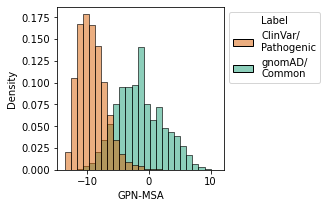

In [10]:
histplot_label(
    V_clinvar,
    hue_order=["ClinVar/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_clinvar.svg",
)

In [16]:
rows = []
for m in tqdm(dataset_models["ClinVar"]):
    y_true = V_clinvar.label=="Pathogenic"
    y_score = -V_clinvar[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append([m, AUROC, AUPRC])
results_clinvar = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUROC", ascending=False)
results_clinvar

100%|██████████| 56/56 [00:01<00:00, 36.29it/s]


,Model,AUROC,AUPRC
28,multiz100way/89/256/128/True/defined.phastCons...,0.966573,0.977901
12,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794
30,multiz100way/89/256/128/True/defined.phastCons...,0.966203,0.977623
29,multiz100way/89/256/128/True/defined.phastCons...,0.966161,0.977664
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555
11,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538
54,multiz100way/89/128/64/True/defined.phastCons....,0.965504,0.977112
53,multiz100way/89/128/64/True/defined.phastCons....,0.965352,0.976988
52,multiz100way/89/128/64/True/defined.phastCons....,0.965173,0.976840
36,multiz100way/89/128/64/True/defined.phastCons....,0.964764,0.976415


In [17]:
n_pos, n_neg = (V_clinvar.label=="Pathogenic").sum(), (V_clinvar.label=="Common").sum()
clinvar_title = f"ClinVar pathogenic vs.\ngnomAD common (missense)\nn={n_pos} vs. {n_neg}"
pos_prop = n_pos/(n_pos+n_neg)
clinvar_title

'ClinVar pathogenic vs.\ngnomAD common (missense)\nn=21275 vs. 13117'

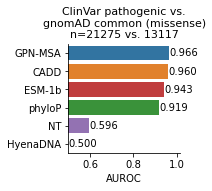

In [19]:
barplot(
    results_clinvar[results_clinvar.Model.isin([
        models[0], "CADD", "phyloP", "NT", "HyenaDNA", "ESM-1b",
    ])].replace(models[0], "GPN-MSA"),
    "AUROC",
    clinvar_title,
    figsize=(2,2),
    #save_path="clinvar_auroc.svg",
)

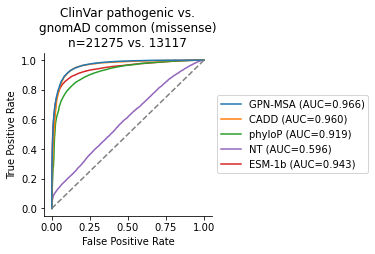

In [19]:
plot_curve(
    V_clinvar,
    results_clinvar[results_clinvar.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
    ])],
    "ROC",
    title,
    #save_path="clinvar_roc.svg",
)

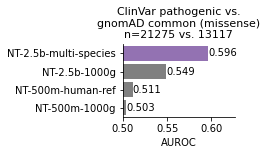

In [21]:
barplot(
    results_clinvar[results_clinvar.Model.isin([
         "NT-500m-human-ref", "NT-500m-1000g", "NT-2.5b-1000g", "NT",
    ])].replace("NT", "NT-2.5b-multi-species"),
    "AUROC",
    clinvar_title,
    figsize=(2,2*2/3),
    #save_path="clinvar_auroc_NT.pdf",
)

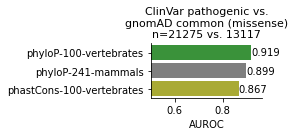

In [24]:
barplot(
    results_clinvar[results_clinvar.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    "AUROC",
    clinvar_title,
    figsize=(2,2*1/2),
    #save_path="clinvar_auroc_conservation.svg"
)

### Stratifying by conservation

In [25]:
log_pval_thresh = -np.log10(0.05)  # 1.3
V_clinvar["conservation"] = "neutral"
V_clinvar.loc[V_clinvar.phyloP < -log_pval_thresh, "conservation"] = "conserved"
V_clinvar.loc[V_clinvar.phyloP > log_pval_thresh, "conservation"] = "accelerated"
V_clinvar.conservation.value_counts()

conservation
conserved      24369
neutral         8633
accelerated     1390
Name: count, dtype: int64

In [27]:
rows = []
for c in V_clinvar.conservation.unique():
    V_c = V_clinvar[V_clinvar.conservation==c]
    for m in dataset_models["ClinVar"]:
        AUROC = roc_auc_score(V_c.label=="Pathogenic", -V_c[m])
        AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
        rows.append([c, m, AUROC, AUPRC])
results_clinvar_strat = pd.DataFrame(rows, columns=["Conservation", "Model", "AUROC", "AUPRC"])
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC
0,neutral,GPN-MSA,0.916170,0.780884
1,neutral,CADD,0.895336,0.714260
2,neutral,phyloP,0.663319,0.254761
3,neutral,phyloP-241-mammals,0.637950,0.302476
4,neutral,phastCons-100-vertebrates,0.769634,0.394395
5,neutral,NT-500m-human-ref,0.499749,0.151674
6,neutral,NT-500m-1000g,0.481755,0.145583
7,neutral,NT-2.5b-1000g,0.526618,0.159958
8,neutral,NT,0.572771,0.202702
9,neutral,ESM-1b,0.882713,0.764948


In [63]:
def get_subtitle(c):
    n_pos, n_neg = V_clinvar[V_clinvar.conservation==c].label.value_counts()[["Pathogenic", "Common"]].values
    return f"{c} (n={n_pos} vs. {n_neg})"

results_clinvar_strat["subtitle"] = results_clinvar_strat.Conservation.apply(get_subtitle)
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC,subtitle
0,neutral,GPN-MSA,0.916170,0.780884,neutral (n=1371 vs. 7262)
1,neutral,CADD,0.895336,0.714260,neutral (n=1371 vs. 7262)
2,neutral,phyloP,0.663319,0.254761,neutral (n=1371 vs. 7262)
3,neutral,phyloP-241-mammals,0.637950,0.302476,neutral (n=1371 vs. 7262)
4,neutral,phastCons-100-vertebrates,0.769634,0.394395,neutral (n=1371 vs. 7262)
5,neutral,NT-500m-human-ref,0.499749,0.151674,neutral (n=1371 vs. 7262)
6,neutral,NT-500m-1000g,0.481755,0.145583,neutral (n=1371 vs. 7262)
7,neutral,NT-2.5b-1000g,0.526618,0.159958,neutral (n=1371 vs. 7262)
8,neutral,NT,0.572771,0.202702,neutral (n=1371 vs. 7262)
9,neutral,ESM-1b,0.882713,0.764948,neutral (n=1371 vs. 7262)


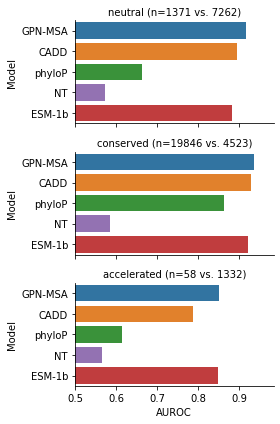

In [66]:
g = sns.catplot(
    data=results_clinvar_strat[
        results_clinvar_strat.Model.isin([
            "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
        ])
    ],
    x="AUROC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}")
g.set(xlim=0.5);

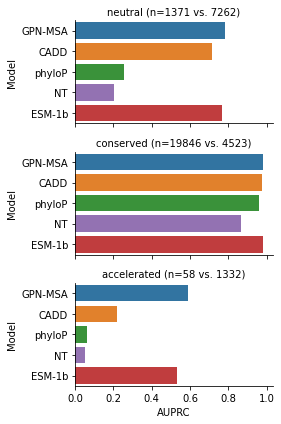

In [69]:
g = sns.catplot(
    data=results_clinvar_strat[
        results_clinvar_strat.Model.isin([
            "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
        ])
    ],
    x="AUPRC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}");
#g.set(xlim=0.5);

## COSMIC frequent vs. gnomAD common (missense)

In [25]:
V_cosmic = V[
    (V.source == "COSMIC") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_cosmic.dropna(subset=dataset_models["COSMIC"], inplace=True)
V_cosmic.label.value_counts()

label
Common      13118
Frequent      189
Name: count, dtype: int64

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

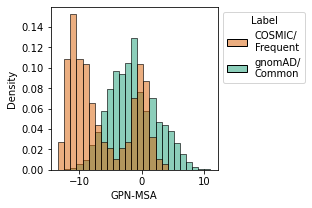

In [19]:
histplot_label(
    V_cosmic,
    hue_order=["COSMIC/\nFrequent", "gnomAD/\nCommon"],
    #save_path="hist_cosmic.svg",
)

In [26]:
rows = []
for m in tqdm(dataset_models["COSMIC"]):
    y_true = V_cosmic.label=="Frequent"
    y_score = -V_cosmic[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append([m, AUROC, AUPRC])
results_cosmic = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUPRC", ascending=False)
results_cosmic

100%|██████████| 51/51 [00:00<00:00, 74.56it/s]


,Model,AUROC,AUPRC
25,multiz100way/89/256/128/True/defined.phastCons...,0.757613,0.368041
23,multiz100way/89/256/128/True/defined.phastCons...,0.757706,0.357106
24,multiz100way/89/256/128/True/defined.phastCons...,0.757117,0.350975
0,multiz100way/89/128/64/True/defined.phastCons....,0.758927,0.348005
6,multiz100way/89/128/64/True/defined.phastCons....,0.758857,0.342592
47,multiz100way/89/128/64/True/defined.phastCons....,0.760038,0.342336
20,multiz100way_vertebrates/51/128/64/True/define...,0.758469,0.339153
48,multiz100way/89/128/64/True/defined.phastCons....,0.760236,0.334579
7,multiz100way/89/128/64/True/defined.phastCons....,0.759372,0.334161
33,multiz100way/89/128/64/True/defined.phastCons....,0.763234,0.333908


In [29]:
n_pos, n_neg = (V_cosmic.label=="Frequent").sum(), (V_cosmic.label=="Common").sum()
cosmic_title = f"COSMIC frequent vs. \ngnomAD common (missense) \n n = {n_pos} vs. {n_neg}"
cosmic_pos_prop = n_pos/(n_pos+n_neg)
cosmic_title

'COSMIC frequent vs. \ngnomAD common (missense) \n n = 189 vs. 13118'

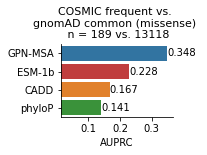

In [30]:
barplot(
    results_cosmic[results_cosmic.Model.isin([
        models[0], "CADD", "phyloP", "ESM-1b",
    ])].replace(models[0], "GPN-MSA"),
    "AUPRC",
    cosmic_title,
    pos_prop=cosmic_pos_prop,
    figsize=(2,2*2/3),
    #save_path="cosmic_auprc.svg",
)

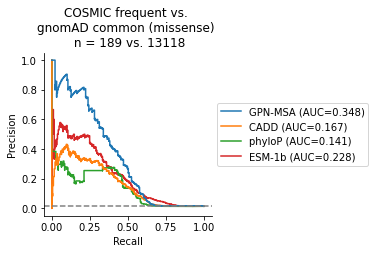

In [28]:
plot_curve(
    V_cosmic,
    results_cosmic[results_cosmic.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "ESM-1b",
    ])],
    "PR",
    title,
    pos_label="Frequent",
    pos_prop=pos_prop,
    save_path="cosmic_pr_curve.svg",
)

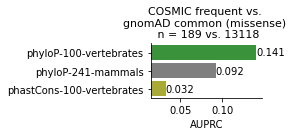

In [32]:
barplot(
    results_cosmic[results_cosmic.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    "AUPRC",
    cosmic_title,
    pos_prop=cosmic_pos_prop,
    figsize=(2,2*1/2),
    #save_path="cosmic_auprc_conservation.svg",
)

## OMIM pathogenic vs. gnomAD common (regulatory)

In [33]:
omim_variant_type_dict = {
    "5_prime_UTR_variant": "5' UTR",
    "upstream_gene_variant": "Promoter",
    "intergenic_variant": "Enhancer",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
}
cs = list(omim_variant_type_dict.keys())
cs

['5_prime_UTR_variant',
 'upstream_gene_variant',
 'intergenic_variant',
 '3_prime_UTR_variant',
 'non_coding_transcript_exon_variant']

In [34]:
V_omim = V[
    (V.source == "OMIM") |
    (
        (V.label == "Common") &
        np.any([V.consequence.str.contains(c) for c in cs], axis=0) &
        ~V.consequence.str.contains("missense")
    )
].copy()
V_omim.label.value_counts()

label
Common        2321067
Pathogenic        406
Name: count, dtype: int64

In [35]:
V_omim.loc[V_omim.source=="OMIM", "consequence"] = V_omim[V_omim.source=="OMIM"].consequence.str.split(" ").str[:-1].str.join(sep=" ").str.replace("’", "'").replace("RNA Gene", "ncRNA")

In [36]:
for x, y in omim_variant_type_dict.items():
    V_omim[y] = False
    V_omim.loc[(V_omim.source=="OMIM") & (V_omim.consequence==y), y] = True
    V_omim.loc[(V_omim.source!="OMIM") & (V_omim.consequence.str.contains(x)), y] = True

In [37]:
def get_subtitle(c, n_pathogenic, n_common):
    return f"{c}\nn={n_pathogenic} vs. {n_common}"

pos_prop = []

consequence_models = dataset_models["OMIM"]

rows = []
for c in consequence_models:
    V_c = V_omim.copy() if c=="all" else V_omim[V_omim[c]].copy()
    V_c.dropna(subset=consequence_models[c], inplace=True)
    
    if c == "all":
        V_omim_all = V_c
    
    n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
    subtitle = get_subtitle(c, n_pos, n_neg)
    pos_prop.append(n_pos/(n_pos+n_neg))
    
    for m in tqdm(consequence_models[c]):
        AUROC = roc_auc_score(V_c.label=="Pathogenic", -V_c[m])
        AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
        rows.append([m, c, AUROC, AUPRC, subtitle])
results_omim = pd.DataFrame(rows, columns=["Model", "Consequence", "AUROC", "AUPRC", "subtitle"])
results_omim

100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


,Model,Consequence,AUROC,AUPRC,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,all,0.927967,0.116074,all\nn=406 vs. 2284702
1,CADD,all,0.936614,0.032636,all\nn=406 vs. 2284702
2,phyloP,all,0.869517,0.038891,all\nn=406 vs. 2284702
3,phyloP-241-mammals,all,0.881639,0.028575,all\nn=406 vs. 2284702
4,phastCons-100-vertebrates,all,0.835147,0.005967,all\nn=406 vs. 2284702
...,...,...,...,...,...
70,multiz100way/89/128/64/True/defined.phastCons....,ncRNA,0.963811,0.083703,ncRNA\nn=60 vs. 175574
71,CADD,ncRNA,0.974633,0.048741,ncRNA\nn=60 vs. 175574
72,phyloP,ncRNA,0.911295,0.040859,ncRNA\nn=60 vs. 175574
73,phyloP-241-mammals,ncRNA,0.913507,0.027986,ncRNA\nn=60 vs. 175574


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

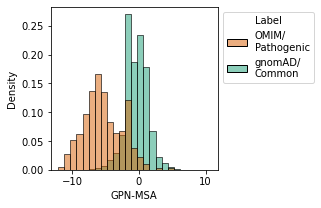

In [55]:
histplot_label(
    V_omim_all,
    hue_order=["OMIM/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_omim.svg",
)

In [35]:
replacements = {"Promoter": "promoter", "Enhancer": "enhancer"}

for key, value in replacements.items():
    results_omim['subtitle'] = results_omim['subtitle'].str.replace(key, value)

In [100]:
def omim_plot(
    df,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    g = sns.catplot(
        data=df,
        y="Model",
        x="AUPRC",
        col="subtitle",
        height=1.5,
        aspect=1.0,
        kind="bar",
        col_wrap=3,
        sharex=False,
        sharey=True,
        legend=False,
        palette=palette,
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}");
    for i, ax in enumerate(g.axes):
        ax.set_xlim(left=pos_prop[i])
        ax.set_ylabel("")
    g.fig.suptitle(title, y=y, fontsize=12, x=x)
    g.figure.subplots_adjust(wspace=1.0, hspace=1.0)

    for ax in g.axes.flat:
        for bar in ax.patches:
            ax.text(
                bar.get_width(),  # X position, here at the end of the bar
                bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
                f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
                va='center'  # Vertical alignment
            )
    
    """
    # Get current x-tick labels
    catplot = g
    current_labels = [item.get_text() for item in catplot.ax.get_xticklabels()]

    # Convert to float and format with desired number of significant figures
    n_significant_figures = 2
    formatted_labels = [f"{float(label):.{n_significant_figures}g}" if label.replace('.','',1).isdigit() else label for label in current_labels]

    # Set new labels
    catplot.set_xticklabels(formatted_labels)
    """

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

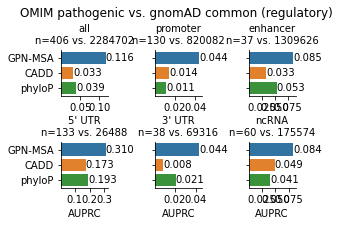

In [101]:
omim_plot(
    results_omim[results_omim.Model.isin([
        "GPN-MSA", "CADD", "phyloP",
    ])],
    x=0.6,
    #save_path="omim_auprc.svg",
)

In [37]:
title = "OMIM pathogenic vs.\ngnomAD common (regulatory)" + "\n" + results_omim[results_omim.Consequence=="all"].subtitle.iloc[0]

In [38]:
def omim_curve_plot(
    subset_models,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    consequence_models = dataset_models["OMIM"]
    plot_f = PrecisionRecallDisplay
    metric = "AUPRC"
    xlabel = 'Recall'
    ylabel = 'Precision'
    pos_label = "Pathogenic"

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 5))
    
    rows = []
    i = 0
    for c in consequence_models:
        ax = axes.flat[i]
        V_c = V_omim.copy() if c=="all" else V_omim[V_omim[c]].copy()
        V_c.dropna(subset=consequence_models[c], inplace=True)

        n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
        pos_prop = n_pos/(n_pos+n_neg)
        subtitle = get_subtitle(c, n_pos, n_neg)

        for m in np.array(consequence_models[c])[::-1]:
            if m not in subset_models: continue
            AUC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
            plot_f.from_predictions(V_c.label==pos_label, -V_c[m], name=m, ax=ax, label=f"{m}\n(AUC={AUC:.3f})", color=palette[m])

        ax.axhline(y=pos_prop, linestyle="--", color="gray")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        sns.despine()

        ax.legend();
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # reverse the order
        handles, labels = handles[::-1], labels[::-1]
        # create the legend with the reversed order
        ax.legend(handles, labels)#, loc='center left', bbox_to_anchor=(1, 0.5))    

        ax.set_title(subtitle)
        i += 1
    
    fig.suptitle(title, y=y, fontsize=12, x=x)
    plt.subplots_adjust(hspace=0.5) 

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

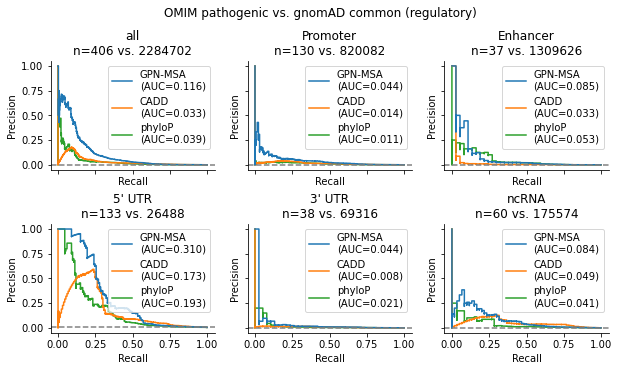

In [39]:
omim_curve_plot(
    subset_models=["GPN-MSA", "CADD", "phyloP"],
    save_path="omim_pr_curves.svg",
)

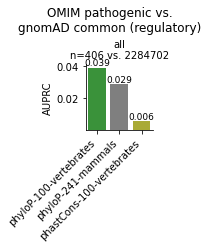

In [57]:
omim_plot(
    results_omim[(results_omim.Consequence=="all") & results_omim.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    title="OMIM pathogenic vs.\ngnomAD common (regulatory)",
    x=0.2, y=1.15,
    #save_path="omim_auprc_conservation.svg",
)

## gnomAD rare vs. common

In [38]:
V_gnomad = V[V.source == "gnomAD"].copy()
V_gnomad.label.value_counts()

label
Rare      4869209
Common    4869209
Name: count, dtype: int64

In [39]:
# Drop 32 variants with MAF 1/n but AF > 0.5
# In the case of GPN-MSA and other LLR-based methods, it would be easy
# to include these variants in the analysis by "folding" (considering the major as the reference)
# (flipping the scores when AF > 0.5)
# but CADD and phyloP are only computed assuming a fixed ref
V_gnomad = V_gnomad[V_gnomad.AC != V_gnomad.AN - 1].copy()
V_gnomad.label.value_counts()

label
Common    4869209
Rare      4869177
Name: count, dtype: int64

In [40]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    if threshold == df[model_name].max():  # happens with SpliceAI
        print("WARNING: threshold == max(score)", threshold_quantile, model_name)
        return None, None, None, None, None, None
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    odds_ratio, p_value, min_counts, ci_lower, ci_upper = _compute_odds_ratio(df)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper, threshold

def _compute_odds_ratio(df):
    group_counts = df.groupby(["label", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    #if np.isinf(odds_ratio):
    #    print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [41]:
threshold_quantiles = np.logspace(-5, -1, 21)
#threshold_quantiles = np.logspace(-2, 0, 11)[:-1]

consequence_models = dataset_models["gnomAD"]

rows = []
for c in list(consequence_models.keys()):
    #if c != "missense": continue  # temporary
    if c != "all": continue  # temporary
    print(c)
    if c == "all":
        df_c = V_gnomad
    else:
        df_c = V_gnomad[V_gnomad.consequence.str.contains(c)]
        # optional filter
        if c != "missense": df_c = df_c[~df_c.consequence.str.contains("missense")]
        
    df_c = df_c.dropna(subset=consequence_models[c])
    
    if c == "all":
        #df_c.to_parquet("subset_4_gnomad_vs_gnomad.parquet", index=False)
        #print(len(df_c))
        V_gnomad_all = df_c
        #raise Exception("debug")
    # optional subsample
    #df_c = df_c.groupby("label").sample(n=df_c.label.value_counts().min(), random_state=42).sample(frac=1, random_state=42)
    
    for m in tqdm(consequence_models[c]):
        subtitle = get_subtitle(c, (df_c.label=="Rare").sum(), (df_c.label=="Common").sum())
        for tq in threshold_quantiles:
            if m in ablation_models[1:] and tq != 1e-3: continue
            OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
            rows.append([m, c, tq, OR, p_value, min_counts, cil, ciu, threshold, subtitle])
results_gnomad = pd.DataFrame(rows, columns=["Model", "Consequence", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold", "subtitle"])
results_gnomad

all


100%|██████████| 50/50 [14:35<00:00, 17.52s/it]  


,Model,Consequence,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,all,0.000010,inf,6.373653e-30,0,NaN,inf,-12.775453,all\nn=4812825 vs. 4811795
1,multiz100way/89/128/64/True/defined.phastCons....,all,0.000016,151.972238,1.369111e-44,1,20.432551,1130.331733,-12.642571,all\nn=4812825 vs. 4811795
2,multiz100way/89/128/64/True/defined.phastCons....,all,0.000025,240.960439,3.517286e-71,1,32.475543,1787.866456,-12.456656,all\nn=4812825 vs. 4811795
3,multiz100way/89/128/64/True/defined.phastCons....,all,0.000040,190.974202,1.939373e-111,2,46.257652,788.434866,-12.227230,all\nn=4812825 vs. 4811795
4,multiz100way/89/128/64/True/defined.phastCons....,all,0.000063,201.648730,3.691003e-176,3,63.368482,641.678780,-11.959467,all\nn=4812825 vs. 4811795
...,...,...,...,...,...,...,...,...,...,...
165,multiz100way/89/128/64/True/defined.phastCons....,all,0.001000,35.440655,0.000000e+00,265,31.289100,40.143054,-9.390625,all\nn=4812825 vs. 4811795
166,multiz100way/89/128/64/True/defined.phastCons....,all,0.001000,36.987425,0.000000e+00,254,32.570025,42.003948,-9.179688,all\nn=4812825 vs. 4811795
167,multiz100way/89/128/64/True/defined.phastCons....,all,0.001000,34.462112,0.000000e+00,272,30.472852,38.973614,-9.226562,all\nn=4812825 vs. 4811795
168,multiz100way/89/128/64/True/defined.phastCons....,all,0.001000,35.949228,0.000000e+00,261,31.708704,40.756854,-9.171875,all\nn=4812825 vs. 4811795


/tmp/ipykernel_2801289/2596275445.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V["Label"] = V.source + "/\n" + V.label
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaf

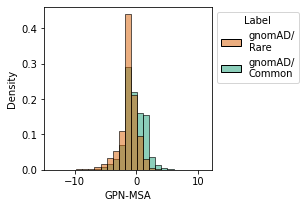

In [ ]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
    #save_path="hist_gnomad.svg",
)

(0.0, 0.007)

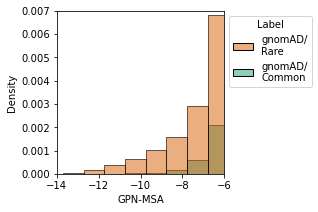

In [116]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
)
plt.xlim(-14, -6)
plt.ylim(0, 7e-3)
#plt.savefig(plot_dir + "hist_gnomad_zoom.svg", bbox_inches="tight")

In [41]:
print("Careful if inf, should handle separately: ", results_gnomad["Odds ratio"].max())

Careful if inf, should handle separately:  89.25922147651006


In [42]:
limit_per_consequence = results_gnomad.query("min_counts < 10").groupby("Consequence")["Quantile threshold"].max()
limit_per_consequence

Consequence
missense    0.025119
Name: Quantile threshold, dtype: float64

In [43]:
def above_limit(r):
    try:
         l = limit_per_consequence[r.Consequence]
    except:
        return True
    return r["Quantile threshold"] > l

results_gnomad["above_limit"] = results_gnomad.apply(above_limit, axis=1)

In [44]:
results_gnomad[results_gnomad.above_limit].min_counts.min()

14

In [45]:
results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min()

0.039810717055349734

In [24]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "non_coding_transcript_exon": "ncRNA",
}

for key, value in replacements.items():
    results_gnomad['subtitle'] = results_gnomad['subtitle'].str.replace(key, value)
    results_gnomad['Consequence'] = results_gnomad['Consequence'].str.replace(key, value)

In [35]:
x = results_gnomad.subtitle.drop_duplicates()
x = "``" + results_gnomad.Consequence.drop_duplicates() + "'': " + x.str.split('\n').str[-1].str.replace("n=", "$n=$ ")
x = ", ".join(x.values)
x

"``all'': $n=$ 4812825 vs. 4811795, ``missense'': $n=$ 37757 vs. 13118, ``synonymous'': $n=$ 18647 vs. 17566, ``5' UTR'': $n=$ 35538 vs. 26488, ``3' UTR'': $n=$ 82954 vs. 69316, ``upstream-of-gene'': $n=$ 849851 vs. 820082, ``downstream-of-gene'': $n=$ 869964 vs. 852410, ``intron'': $n=$ 1804469 vs. 1690417, ``intergenic'': $n=$ 1226643 vs. 1309626, ``ncRNA'': $n=$ 183960 vs. 175574"

In [79]:
def gnomad_plot(df, save_path=None, y=1.15, height=2.1):
    g = sns.relplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        col="subtitle",
        #col="Consequence",
        height=height,
        kind="line",
        marker="o",
        col_wrap=min(5, len(df.subtitle.unique())),
        facet_kws={'sharey': False, 'sharex': False},
        palette=palette,
        markersize=5,
    )

    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=1.0)
    g.fig.subplots_adjust(
        hspace=1.2,
        #wspace=0.5,
    ) # 1.0 # modification
    plt.suptitle("gnomAD rare vs. common", y=y);
    for ax in g.axes.flat:
        xticks = df[(df.p_value<=0.05) & (df.above_limit)]["Quantile threshold"].drop_duplicates().values
        xticks = xticks[::2]
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{x:.2e}" for x in xticks])

    #    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
        ax.tick_params(axis='x', rotation=45)

    """
    for ax, subtitle in zip(g.axes.flat, g.col_names):
        ax.set_title(ax.get_title(), fontweight='bold')
        
        xticks = [1e-4, 1e-3, 1e-2, 1e-1]
        ax.set_xticks(xticks)
        left = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min() * 0.8
        right = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].max() / 0.8
        ax.set_xlim(left=left, right=right)
        ax.set_xlabel("Quantile threshold")

        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Consequence'] == subtitle) & (df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")
    """
  
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

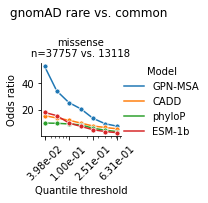

In [81]:
import warnings
warnings.filterwarnings('ignore')
gnomad_plot(
    results_gnomad[results_gnomad.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "ESM-1b", "SpliceAI",
    ])],
    y=1.13,
    #save_path="gnomad_or.svg",
    #save_path="gnomad_or_missense.pdf",
)

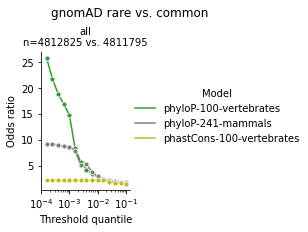

In [90]:
gnomad_plot(
    results_gnomad[(results_gnomad.Consequence=="all") & results_gnomad.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    y=1.25, height=2.5,
    #save_path="gnomad_or_conservation.svg",
)

## gnomAD Enformer set (low-frequency vs. common)

In [161]:
V_enformer = V_enformer[V_enformer.AF < 0.95]
V_enformer["label"] = "Common"
V_enformer.loc[V_enformer.AF < 0.05, "label"] = "Rare"  # for convenience, actually low-frequency
V_enformer.label.value_counts()

label
Rare      3589541
Common    2733438
Name: count, dtype: int64

In [166]:
threshold_quantiles = np.logspace(-5, -1, 21)

rows = []

df_c = V_enformer.dropna(subset=models_enformer)

for m in tqdm(models_enformer):
    for tq in threshold_quantiles:
        OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
        rows.append([m, tq, OR, p_value, min_counts, cil, ciu, threshold])
results_enformer = pd.DataFrame(rows, columns=["Model", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold"])
results_enformer

100%|██████████| 8/8 [08:00<00:00, 60.03s/it]


,Model,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold
0,multiz100way/89/128/64/True/defined.phastCons....,0.000010,4.581095,7.919088e-07,9,2.229671,9.412345,-9.988813
1,multiz100way/89/128/64/True/defined.phastCons....,0.000016,4.635664,4.460667e-10,14,2.603645,8.253576,-9.594156
2,multiz100way/89/128/64/True/defined.phastCons....,0.000025,4.481585,8.118485e-15,23,2.854272,7.036682,-9.281250
3,multiz100way/89/128/64/True/defined.phastCons....,0.000040,3.369524,9.314497e-17,46,2.430696,4.670964,-8.995733
4,multiz100way/89/128/64/True/defined.phastCons....,0.000063,2.923843,2.606757e-21,82,2.281567,3.746923,-8.695312
...,...,...,...,...,...,...,...,...
163,Enformer_linf,0.015849,1.109611,6.151662e-58,40403,1.095242,1.124169,-0.101257
164,Enformer_linf,0.025119,1.089844,3.599367e-62,64691,1.078580,1.101224,-0.077393
165,Enformer_linf,0.039811,1.081657,2.896735e-80,103098,1.072710,1.090678,-0.058197
166,Enformer_linf,0.063096,1.071810,1.620383e-96,164331,1.064681,1.078987,-0.043030


In [167]:
n_pos, n_neg = (df_c.label=="Rare").sum(), (df_c.label=="Common").sum()
title = f"gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)"  #\nn={n_pos} vs. {n_neg}"
title

'gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)'

In [168]:
limit = results_enformer.query("min_counts < 10")["Quantile threshold"].max()
limit

9.999999999999999e-06

In [169]:
def above_limit(r):
    return np.isnan(limit) or r["Quantile threshold"] > limit + 1e-8

results_enformer["above_limit"] = results_enformer.apply(above_limit, axis=1)

In [182]:
def enformer_plot(df, save_path=None):
    plt.figure(figsize=(2,2))
    g = sns.lineplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        marker="o",
        palette=palette,
        markersize=5,
    )
    #for ax in g.axes: ax.axhline(1, ls='--', color="grey")
    #g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=0.75)
    #plt.suptitle("gnomAD rare vs. common", y=0.9);
    sns.despine()
    #ax.set_ylim(bottom=pos_prop[i])
    plt.ylim(bottom=1)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    #g.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    
    ax = g     
    xticks = [1e-4, 1e-3, 1e-2, 1e-1]
    ax.set_xticks(xticks)

    if "GPN-MSA" in df.Model.unique():
        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")

    plt.title(title, fontsize=11);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

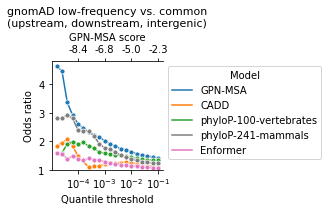

In [186]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        models[0], "CADD", "phyloP", "Enformer_l1", "phyloP-241-mammals",
    ])].replace({"Enformer_l1": "Enformer", "phyloP": "phyloP-100-vertebrates", models[0]: "GPN-MSA"}),
    #save_path="gnomad_or_enformer.svg",
)

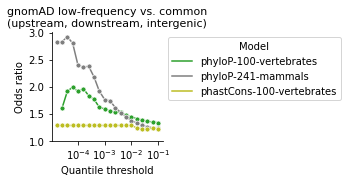

In [184]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    #save_path="gnomad_or_enformer_conservation.svg",
)

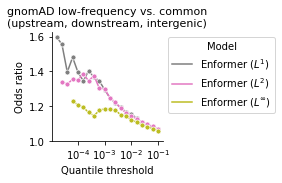

In [185]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        "Enformer_l1", "Enformer_l2", "Enformer_linf",
    ])].replace({
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    #save_path="gnomad_or_enformer_norms.pdf",
)

## GWAS

In [57]:
for m in [models[0]]:
    if m in V_gwas.columns:
        print(m)
        V_gwas[m] = -V_gwas[m].abs()

multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True


In [82]:
rows = []
total_n_pos = 0
total_n_neg = 0
for chrom in tqdm(V_gwas.chrom.unique()):
    V_c = V_gwas[V_gwas.chrom==chrom]
    V_c = V_c.dropna(subset=models_gwas)
    V_c = V_c[V_c.duplicated("match_group", keep=False)]
    n_pos, n_neg = V_c.label.sum(), (~V_c.label).sum()
    if n_pos == 0: continue
    total_n_pos += n_pos
    total_n_neg += n_neg
    subtitle = f"(n={n_pos} vs. {n_neg})"
    for m in models_gwas:
        rows.append([chrom, subtitle, m, roc_auc_score(V_c.label, -V_c[m])])
results_gwas = pd.DataFrame(rows, columns=["Chrom", "subtitle", "Model", "AUROC"])
results_gwas

100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


,Chrom,subtitle,Model,AUROC
0,1,(n=173 vs. 173),multiz100way/89/128/64/True/defined.phastCons....,0.674597
1,1,(n=173 vs. 173),CADD,0.674864
2,1,(n=173 vs. 173),phyloP,0.652260
3,1,(n=173 vs. 173),phyloP-241-mammals,0.625881
4,1,(n=173 vs. 173),phastCons-100-vertebrates,0.607404
...,...,...,...,...
1161,22,(n=42 vs. 42),multiz100way/89/128/64/True/defined.phastCons....,0.646259
1162,22,(n=42 vs. 42),multiz100way/89/128/64/True/defined.phastCons....,0.662132
1163,22,(n=42 vs. 42),multiz100way/89/128/64/True/defined.phastCons....,0.633220
1164,22,(n=42 vs. 42),multiz100way/89/128/64/True/defined.phastCons....,0.642857


In [83]:
results_gwas_main = results_gwas[~results_gwas.Model.isin(
    [f"{m}.LogisticRegression" for m in ablation_models] + models[:1]
)]
results_gwas_main.Model = results_gwas_main.Model.str.replace(".LogisticRegression", "")
results_gwas_main.Model = [model_renaming.get(m, m) for m in results_gwas_main.Model]
results_gwas_main.Model = results_gwas_main.Model.replace(models[0], "GPN-MSA")
results_gwas_main

,Chrom,subtitle,Model,AUROC
1,1,(n=173 vs. 173),CADD,0.674864
2,1,(n=173 vs. 173),phyloP,0.652260
3,1,(n=173 vs. 173),phyloP-241-mammals,0.625881
4,1,(n=173 vs. 173),phastCons-100-vertebrates,0.607404
5,1,(n=173 vs. 173),GPN-MSA,0.743927
...,...,...,...,...
1117,22,(n=42 vs. 42),phastCons-100-vertebrates,0.651361
1118,22,(n=42 vs. 42),GPN-MSA,0.651927
1119,22,(n=42 vs. 42),Enformer,0.806689
1120,22,(n=42 vs. 42),NT,0.638889


In [86]:
title_gwas = f"GWAS causal vs. not\nn={total_n_pos} vs. {total_n_neg}"
title_gwas

'GWAS causal vs. not\nn=1981 vs. 1981'

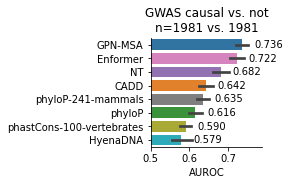

In [92]:
# TODO: add title
# TODO: add numerical values
plt.figure(figsize=(2,2))
g = sns.barplot(
    data=results_gwas_main,
    x="AUROC", y="Model",
    palette=palette,
    order=results_gwas_main.groupby("Model").AUROC.mean().sort_values(ascending=False).index.values,
)

for bar in g.patches:
    g.text(
        bar.get_width() + 0.03,  # X position, here at the end of the bar
        bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
        f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
        va='center'  # Vertical alignment
    )

plt.title(title_gwas)
plt.ylabel("")
g.set(xlim=0.5);
sns.despine();

## Ablation study

In [106]:
results_gwas_ablation = results_gwas[
    results_gwas.Model.str.contains("LogisticRegression") &
    results_gwas.Model.str.contains("multiz")
]
results_gwas_ablation = results_gwas_ablation.groupby("Model").AUROC.mean().to_frame().reset_index()
results_gwas_ablation.Model = results_gwas_ablation.Model.str.replace(".LogisticRegression", "")
results_gwas_ablation

,Model,AUROC
0,multiz100way/89/128/64/True/defined.phastCons....,0.658057
1,multiz100way/89/128/64/True/defined.phastCons....,0.732561
2,multiz100way/89/128/64/True/defined.phastCons....,0.732494
3,multiz100way/89/128/64/True/defined.phastCons....,0.714560
4,multiz100way/89/128/64/True/defined.phastCons....,0.728183
5,multiz100way/89/128/64/True/defined.phastCons....,0.701242
6,multiz100way/89/128/64/True/defined.phastCons....,0.732140
7,multiz100way/89/128/64/True/defined.phastCons....,0.712122
8,multiz100way/89/128/64/True/defined.phastCons....,0.736330
9,multiz100way/89/128/64/True/defined.phastCons....,0.651094


In [147]:
results_ablation = [
    df[df.Model.isin(models[:1] + ablation_models)]
    for df in [
        results_clinvar[["Model", "AUROC"]].rename(columns={"AUROC": "ClinVar"}),
        results_cosmic[["Model", "AUPRC"]].rename(columns={"AUPRC": "COSMIC"}),
        results_omim[results_omim.Consequence=="all"][["Model", "AUPRC"]].rename(columns={"AUPRC": "OMIM"}),
        results_gnomad[
            (results_gnomad["Quantile threshold"]==1e-3) & (results_gnomad.Consequence=="all") 
        ][["Model", "Odds ratio"]].rename(columns={"Odds ratio": "gnomAD"}),
        results_gwas_ablation.rename(columns={"AUROC": "GWAS"}),
    ]
]

results_ablation = reduce(lambda x, y: x.merge(y, on="Model", how="left"), results_ablation)
results_ablation

,Model,ClinVar,COSMIC,OMIM,gnomAD,GWAS
0,multiz100way/89/256/128/True/defined.phastCons...,0.966573,0.357106,0.127410,36.659241,0.737470
1,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.334161,0.106964,37.105859,0.733894
2,multiz100way/89/256/128/True/defined.phastCons...,0.966203,0.368041,0.107375,37.328784,0.732380
3,multiz100way/89/256/128/True/defined.phastCons...,0.966161,0.350975,0.115069,37.874235,0.737503
4,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.348005,0.116074,38.350315,0.736330
5,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.342592,0.122366,35.517883,0.733602
6,multiz100way/89/128/64/True/defined.phastCons....,0.965504,0.325528,0.097476,35.949228,0.729384
7,multiz100way/89/128/64/True/defined.phastCons....,0.965352,0.334579,0.116613,34.462112,0.729037
8,multiz100way/89/128/64/True/defined.phastCons....,0.965173,0.342336,0.107573,36.987425,0.732140
9,multiz100way/89/128/64/True/defined.phastCons....,0.964764,0.303342,0.112456,34.056944,0.732652


In [148]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency (no neural net)",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50% most conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_1.00_0.00/medium/0.1/[\d]+/30000/True/True/True": "Train on 100% of genome",
    
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include closest primates",
    r"multiz100way_mammals/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 mammals",
    r"multiz100way_vertebrates/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 vertebrates",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace non-conserved",
    
    r"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 256",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.64": "Window size = 64",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.32": "Window size = 32",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.16": "Window size = 16",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.8": "Window size = 8",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.4": "Window size = 4",
}

In [149]:
results_ablation["Ablation"] = None
for k, v in hparam_name.items():
    results_ablation.loc[results_ablation.Model.str.match(k), "Ablation"] = v
results_ablation = results_ablation.dropna(subset="Ablation")
results_ablation.Ablation.value_counts()

Ablation
Window size = 256                3
Default                          3
Window size = 64                 3
Don't upweight conserved         3
Window size = 32                 3
Don't replace non-conserved      3
51 vertebrates                   3
51 mammals                       3
Window size = 16                 3
Train on 50% most conserved      3
Window size = 8                  3
Train on 100% of genome          3
Include closest primates         3
Window size = 4                  3
w/o MSA                          3
MSA frequency (no neural net)    1
Name: count, dtype: int64

In [150]:
results_ablation = results_ablation.groupby("Ablation")[["ClinVar", "COSMIC", "OMIM", "gnomAD", "GWAS"]].agg(["mean", "std"])
results_ablation.index.name = None
results_ablation = results_ablation.loc[hparam_name.values()]
results_ablation = results_ablation.round(3)
results_ablation

ClinVar        COSMIC          OMIM         \
                                 mean    std   mean    std   mean    std   
Default                         0.966  0.000  0.342  0.007  0.115  0.008   
w/o MSA                         0.582  0.001  0.014  0.000  0.000  0.000   
MSA frequency (no neural net)   0.947    NaN  0.266    NaN  0.030    NaN   
Train on 50% most conserved     0.960  0.001  0.237  0.020  0.122  0.012   
Train on 100% of genome         0.957  0.001  0.207  0.014  0.119  0.002   
Include closest primates        0.950  0.002  0.211  0.007  0.128  0.018   
51 mammals                      0.962  0.001  0.317  0.002  0.067  0.002   
51 vertebrates                  0.964  0.000  0.334  0.005  0.090  0.007   
Don't upweight conserved        0.964  0.000  0.297  0.006  0.122  0.016   
Don't replace non-conserved     0.964  0.000  0.328  0.006  0.102  0.002   
Window size = 256               0.966  0.000  0.359  0.009  0.117  0.010   
Window size = 64                0.965  0.000  0.334  0.008  0.107  0.010   
Window size = 32                0.964  0.000  0.317  0.006  0.107  0.014   
Window size = 16                0.962  0.000  0.242  0.003  0.094  0.009   
Window size = 8                 0.958  0.000  0.188  0.017  0.078  0.008   
Window size = 4                 0.938  0.001  0.134  0.020  0.049  0.002   

                               gnomAD          GWAS         
                                 mean    std   mean    std  
Default                        36.991  1.420  0.735  0.001  
w/o MSA                         1.933  0.029  0.654  0.004  
MSA frequency (no neural net)  17.344    NaN    NaN    NaN  
Train on 50% most conserved    28.690  1.102  0.732  0.002  
Train on 100% of genome        26.516  1.228  0.730  0.001  
Include closest primates       31.541  1.485  0.728  0.003  
51 mammals                     33.343  0.314  0.734  0.003  
51 vertebrates                 33.837  0.496  0.731  0.000  
Don't upweight conserved       34.162  1.032  0.732  0.000  
Don't replace non-conserved    33.122  1.685  0.733  0.001  
Window size = 256              37.287  0.609  0.736  0.003  
Window size = 64               35.800  1.269  0.730  0.002  
Window size = 32               34.945  0.612  0.726  0.003  
Window size = 16               28.581  0.691  0.717  0.003  
Window size = 8                23.325  0.349  0.712  0.000  
Window size = 4                10.182  0.298  0.702  0.001

In [153]:
categories = ["ClinVar", "COSMIC", "OMIM", "gnomAD", "GWAS"]
results_ablation_tex = pd.DataFrame()

def mean_std_str(mean, std):
    if pd.isna(mean):
        return "NA"
    elif pd.isna(std):
        return f"{mean:.3f}"
    else:
        return f"{mean:.3f} ± {std:.3f}"
    
def mean_str(mean, is_gnomad):
    if pd.isna(mean):
        return "NA"
    else:
        if is_gnomad:
            return f"{mean:.1f}"
        else:
            return f"{mean:.3f}"

for category in categories:
    mean_col = (category, "mean")
    std_col = (category, "std")
    
    results_ablation_tex[category] = results_ablation.apply(
        #lambda row: mean_std_str(row[mean_col], row[std_col]), axis=1
        lambda row: mean_str(row[mean_col], category=="gnomAD"), axis=1
    )
results_ablation_tex

,ClinVar,COSMIC,OMIM,gnomAD,GWAS
Default,0.966,0.342,0.115,37.0,0.735
w/o MSA,0.582,0.014,0.000,1.9,0.654
MSA frequency (no neural net),0.947,0.266,0.030,17.3,NA
Train on 50% most conserved,0.960,0.237,0.122,28.7,0.732
Train on 100% of genome,0.957,0.207,0.119,26.5,0.730
Include closest primates,0.950,0.211,0.128,31.5,0.728
51 mammals,0.962,0.317,0.067,33.3,0.734
51 vertebrates,0.964,0.334,0.090,33.8,0.731
Don't upweight conserved,0.964,0.297,0.122,34.2,0.732
Don't replace non-conserved,0.964,0.328,0.102,33.1,0.733


In [154]:
print(results_ablation_tex.to_latex(escape="latex"))

\begin{tabular}{llllll}
\toprule
 & ClinVar & COSMIC & OMIM & gnomAD & GWAS \\
\midrule
Default & 0.966 & 0.342 & 0.115 & 37.0 & 0.735 \\
w/o MSA & 0.582 & 0.014 & 0.000 & 1.9 & 0.654 \\
MSA frequency (no neural net) & 0.947 & 0.266 & 0.030 & 17.3 & NA \\
Train on 50\% most conserved & 0.960 & 0.237 & 0.122 & 28.7 & 0.732 \\
Train on 100\% of genome & 0.957 & 0.207 & 0.119 & 26.5 & 0.730 \\
Include closest primates & 0.950 & 0.211 & 0.128 & 31.5 & 0.728 \\
51 mammals & 0.962 & 0.317 & 0.067 & 33.3 & 0.734 \\
51 vertebrates & 0.964 & 0.334 & 0.090 & 33.8 & 0.731 \\
Don't upweight conserved & 0.964 & 0.297 & 0.122 & 34.2 & 0.732 \\
Don't replace non-conserved & 0.964 & 0.328 & 0.102 & 33.1 & 0.733 \\
Window size = 256 & 0.966 & 0.359 & 0.117 & 37.3 & 0.736 \\
Window size = 64 & 0.965 & 0.334 & 0.107 & 35.8 & 0.730 \\
Window size = 32 & 0.964 & 0.317 & 0.107 & 34.9 & 0.726 \\
Window size = 16 & 0.962 & 0.242 & 0.094 & 28.6 & 0.717 \\
Window size = 8 & 0.958 & 0.188 & 0.078 & 23.3 & 0.712 